1. Two graphs generations
2. Prove that they should be right for bfs and dfs heavy algos
   2.1. save them in  grphml files with the calcualted metrics
3. Create two models that are bfs and dfs heavy
4. Train the models on the two datasets
5. Save the models
6. Load the models and test, check score in 2x2 matrix

create file for these function

Just create the two graph and start the learning on them etc, aztán majd holnap reggel elindírom a pesti pc
Now two small graph is enough, just make the notebook runnable easily

TODO: 

kb hasonló méretű gráfok legyenek - also fokszámeloszlás is hasonló kell legyen? mi más? how is it about the modells only? how is it best suited for dfs really
megcsniálni a másik típusú modelleket (q t parameter switch)
visualization
actually we would need the same nodes and edges, just organized in a different way - also same node degree dist - does same node degree distribution mean same graph? communiy based should have same degrees within community, hierarchical is different?

* plot graph stat calculation time with graph size
* plot the algorithm runtime on same graphs. two lines, x = graph size and type?
* numpy np.darray nem lehet type hint in graph_lib
* in graph_with_communities_analytics: when to save it into graph? i returns graph when? 
* all functions should work with pytorch and networkx too
* all functions should contain their own import? like: C:\Users\csaba\Documents\Coding\git_own\thesis_coding\.venv-thesis_coding-py3.10\Lib\site-packages\torch_geometric\utils\convert.py
* graph visualizer: community vs hiearchical graph = layout, daza/nx graph handled - one function


**Community-based scenario:**
Use datasets that exhibit modularity or clusters of connected components.

* Planetoid("Cora") or CitationFull("Cora"), Citeseer or PubMed
* WikipediaNetwork("chameleon") — known for community-like structure
* Coauthor("CS") — authors grouped by field = communities


**Hierarchical scenario:**
Use datasets with taxonomy or hierarchy in their labels or metadata.

* Amazon("Computers") — hierarchical category labels
* WebKB("cornell") — hierarchy in webpages (faculty, student, project pages)
* TUDataset("ENZYMES") — can be interpreted hierarchically via EC numbers
* TreeDataset



In [1]:
# Imports
import torch
import torch_cluster
from torch_geometric.nn import Node2Vec


import community as community_louvain 
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import WebKB
from tqdm.notebook import tqdm

import ogb
# print(ogb.__version__)

import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import optuna
import networkx as nx
from sklearn.manifold import TSNE

from torch_geometric.utils import from_networkx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

import os
import time
import json
import pickle
import os.path as osp
from pprint import pprint

import importlib
import training
importlib.reload(training)
import graph_vis
importlib.reload(graph_vis)
import graph_creation
importlib.reload(graph_creation)
import utils
importlib.reload(utils)
import train_n2v
importlib.reload(train_n2v)

from ogb.nodeproppred import Evaluator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


Using device: cpu
Random seed set to: 42
p_values: [1, 2]
q_values: [1, 2]
Using device: cpu
Random seed set to: 42
p_values: [1, 2]
q_values: [1, 2]


1. graph creation based on models in thesis
2. add_greedy_modularity_labels_nx 
3. show
4. convert

is there  way to visually check if a graph is y labelled in a good way?

In [2]:
import networkx as nx
import numpy as np

def create_graphs_with_clustering_coeffs(
    num_nodes, 
    clustering_coeff_range=(0.1, 0.8), 
    num_graphs=10, 
    generator_type='watts_strogatz'
):
    clustering_coeffs = np.linspace(clustering_coeff_range[0], clustering_coeff_range[1], num_graphs)
    graphs = []
    
    for target_coeff in clustering_coeffs:
        if generator_type == 'watts_strogatz':
            # Binary search to approach desired clustering coefficient
            p_low, p_high = 0, 1
            p = 0.5
            G = nx.watts_strogatz_graph(num_nodes, k=6, p=p)
            
            for _ in range(20):  # limit number of search iterations
                G = nx.watts_strogatz_graph(num_nodes, k=6, p=p)
                current_coeff = nx.average_clustering(G)
                if abs(current_coeff - target_coeff) < 0.01:
                    break
                if current_coeff > target_coeff:
                    p_low = p
                else:
                    p_high = p
                p = (p_low + p_high) / 2

        elif generator_type == 'powerlaw_cluster':
            p_low, p_high = 0, 1
            p = 0.5
            for _ in range(20):
                G = nx.powerlaw_cluster_graph(num_nodes, m=4, p=p)
                current_coeff = nx.average_clustering(G)
                if abs(current_coeff - target_coeff) < 0.01:
                    break
                if current_coeff > target_coeff:
                    p_high = p
                else:
                    p_low = p
                p = (p_low + p_high) / 2
        else:
            raise ValueError("Unsupported generator type. Choose 'watts_strogatz' or 'powerlaw_cluster'.")

        graphs.append((G, nx.average_clustering(G), nx.transitivity(G)))
        
    return graphs

In [3]:
# Example usage:
graphs = create_graphs_with_clustering_coeffs(
    num_nodes=1000, 
    clustering_coeff_range=(0.1, 0.9), 
    num_graphs=12, 
    generator_type='powerlaw_cluster'
)

# Display clustering coefficients
for i, (G, avg_clust, global_clust) in enumerate(graphs):
    print(f"Graph {i}: Avg Clustering = {avg_clust:.3f}, Global Clustering = {global_clust:.3f}")


Graph 0: Avg Clustering = 0.090, Global Clustering = 0.038
Graph 1: Avg Clustering = 0.179, Global Clustering = 0.064
Graph 2: Avg Clustering = 0.239, Global Clustering = 0.077
Graph 3: Avg Clustering = 0.321, Global Clustering = 0.103
Graph 4: Avg Clustering = 0.381, Global Clustering = 0.106
Graph 5: Avg Clustering = 0.460, Global Clustering = 0.151
Graph 6: Avg Clustering = 0.506, Global Clustering = 0.187
Graph 7: Avg Clustering = 0.514, Global Clustering = 0.160
Graph 8: Avg Clustering = 0.509, Global Clustering = 0.174
Graph 9: Avg Clustering = 0.481, Global Clustering = 0.152
Graph 10: Avg Clustering = 0.492, Global Clustering = 0.150
Graph 11: Avg Clustering = 0.504, Global Clustering = 0.140


In [4]:
# graph_vis.graph_visualizer(graphs[0][0])

In [5]:
data_list = []

for g in graphs:
    graph = g[0]
# 1. graph creation based on models in thesis
# 2. add_greedy_modularity_labels_nx 
# 3. show
# 4. convert
    graph = utils.add_greedy_modularity_labels_nx(graph)
    data_g = utils.nx_to_pytorch_data_converter(graph)
    data_g = utils.create_masks(data_g)
    data_list.append(data_g)

Successfully added 'y' attribute to NetworkX graph with 10 communities found.
Successfully added 'y' attribute to NetworkX graph with 11 communities found.
Successfully added 'y' attribute to NetworkX graph with 10 communities found.
Successfully added 'y' attribute to NetworkX graph with 8 communities found.
Successfully added 'y' attribute to NetworkX graph with 7 communities found.
Successfully added 'y' attribute to NetworkX graph with 7 communities found.
Successfully added 'y' attribute to NetworkX graph with 6 communities found.
Successfully added 'y' attribute to NetworkX graph with 7 communities found.
Successfully added 'y' attribute to NetworkX graph with 7 communities found.
Successfully added 'y' attribute to NetworkX graph with 8 communities found.
Successfully added 'y' attribute to NetworkX graph with 7 communities found.
Successfully added 'y' attribute to NetworkX graph with 7 communities found.


Running with p=1_q=2 = {'embedding_dim': 128, 'walk_length': 70, 'context_size': 14, 'walks_per_node': 18, 'num_negative_samples': 1, 'sparse': True, 'p': 1, 'q': 2}
Model initialization parameters provided as dictionary.
Model initialized
Starting training for 8 epochs...


Epoch 1/8 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 001, Loss: 9.3251, Acc: 0.2033, Duration: 80.81s
    New best model saved with accuracy: 0.2033


Epoch: 002, Loss: 8.0267, Acc: 0.1933, Duration: 101.18s


Epoch: 003, Loss: 6.9152, Acc: 0.2133, Duration: 77.85s
    New best model saved with accuracy: 0.2133


Epoch: 004, Loss: 5.9758, Acc: 0.2233, Duration: 78.84s
    New best model saved with accuracy: 0.2233


Epoch: 005, Loss: 5.1717, Acc: 0.2267, Duration: 80.05s
    New best model saved with accuracy: 0.2267


Epoch: 006, Loss: 4.5104, Acc: 0.2200, Duration: 69.17s


Epoch: 007, Loss: 3.9636, Acc: 0.2333, Duration: 71.47s
    New best model saved with accuracy: 0.2333


Epoch: 008, Loss: 3.5096, Acc: 0.2367, Duration: 74.45s
    New best model saved with accuracy: 0.2367

Training finished.
Total elapsed time: 633.86 seconds
Best test accuracy: 0.2367
Best model state saved to './training_data/models/node2vec_'


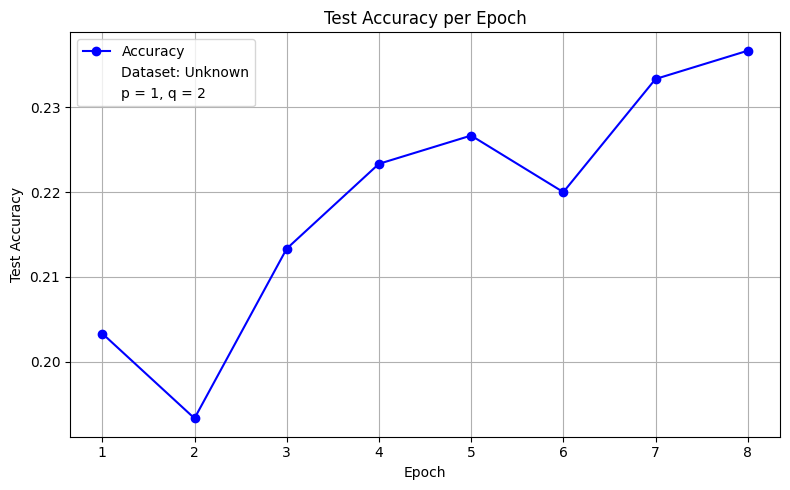

Running with p=2_q=1 = {'embedding_dim': 128, 'walk_length': 70, 'context_size': 14, 'walks_per_node': 18, 'num_negative_samples': 1, 'sparse': True, 'p': 2, 'q': 1}
Model initialization parameters provided as dictionary.
Model initialized
Starting training for 8 epochs...


Epoch: 001, Loss: 9.3755, Acc: 0.1533, Duration: 81.20s
    New best model saved with accuracy: 0.1533


Epoch: 002, Loss: 8.0689, Acc: 0.1600, Duration: 81.01s
    New best model saved with accuracy: 0.1600


Epoch: 003, Loss: 6.9433, Acc: 0.1700, Duration: 71.75s
    New best model saved with accuracy: 0.1700


Epoch: 004, Loss: 5.9926, Acc: 0.1667, Duration: 74.49s


Epoch: 005, Loss: 5.1920, Acc: 0.1700, Duration: 77.36s


Epoch: 006, Loss: 4.5236, Acc: 0.1800, Duration: 80.57s
    New best model saved with accuracy: 0.1800


Epoch: 007, Loss: 3.9718, Acc: 0.1767, Duration: 77.30s


Epoch: 008, Loss: 3.5203, Acc: 0.1633, Duration: 69.62s

Training finished.
Total elapsed time: 613.33 seconds
Best test accuracy: 0.1800
Best model state saved to './training_data/models/node2vec_'


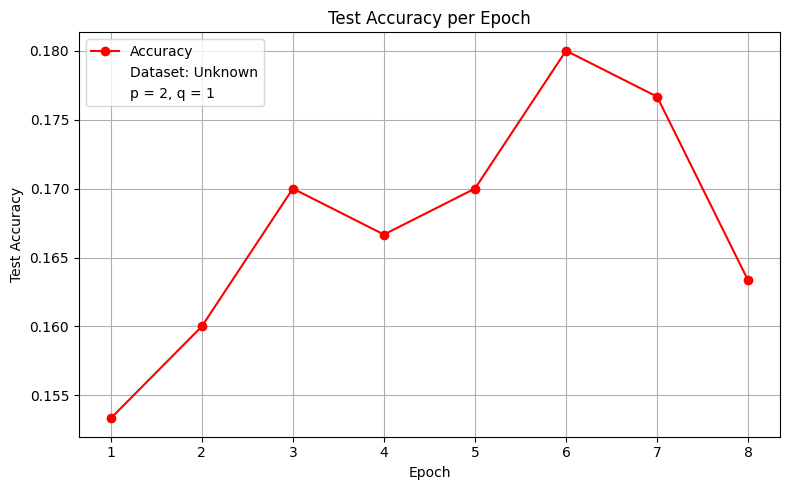

Running with p=1_q=2 = {'embedding_dim': 128, 'walk_length': 70, 'context_size': 14, 'walks_per_node': 18, 'num_negative_samples': 1, 'sparse': True, 'p': 1, 'q': 2}
Model initialization parameters provided as dictionary.
Model initialized
Starting training for 8 epochs...


Epoch: 001, Loss: 9.3071, Acc: 0.1100, Duration: 78.89s
    New best model saved with accuracy: 0.1100


Epoch: 002, Loss: 7.9845, Acc: 0.1200, Duration: 71.96s
    New best model saved with accuracy: 0.1200


Epoch: 003, Loss: 6.8701, Acc: 0.1300, Duration: 68.41s
    New best model saved with accuracy: 0.1300


Epoch: 004, Loss: 5.9394, Acc: 0.1367, Duration: 72.58s
    New best model saved with accuracy: 0.1367


Epoch: 005, Loss: 5.1525, Acc: 0.1500, Duration: 74.37s
    New best model saved with accuracy: 0.1500


Epoch: 006, Loss: 4.5016, Acc: 0.1533, Duration: 68.44s
    New best model saved with accuracy: 0.1533


Epoch: 007, Loss: 3.9584, Acc: 0.1500, Duration: 73.68s


Epoch: 008, Loss: 3.5086, Acc: 0.1533, Duration: 69.87s

Training finished.
Total elapsed time: 578.24 seconds
Best test accuracy: 0.1533
Best model state saved to './training_data/models/node2vec_'


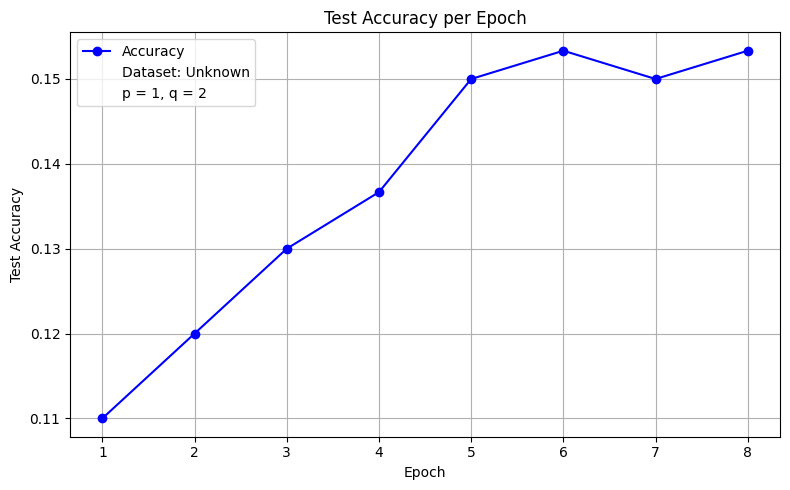

Running with p=2_q=1 = {'embedding_dim': 128, 'walk_length': 70, 'context_size': 14, 'walks_per_node': 18, 'num_negative_samples': 1, 'sparse': True, 'p': 2, 'q': 1}
Model initialization parameters provided as dictionary.
Model initialized
Starting training for 8 epochs...


KeyboardInterrupt: 

In [6]:
train_n2v.train_node2vecs(data_list, 8)

Node type information available for histogram.
     node_type  count
0           0    143
1           1    106
2           2    100
3           3     82
4           4     81
5           5     77
6           6     52
7           7     51
8           8     50
9           9     35
10         10     35
11         11     34
12         12     30
13         13     29
14         14     25
15         15     22
16         16     17
17         17     16
18         18     15


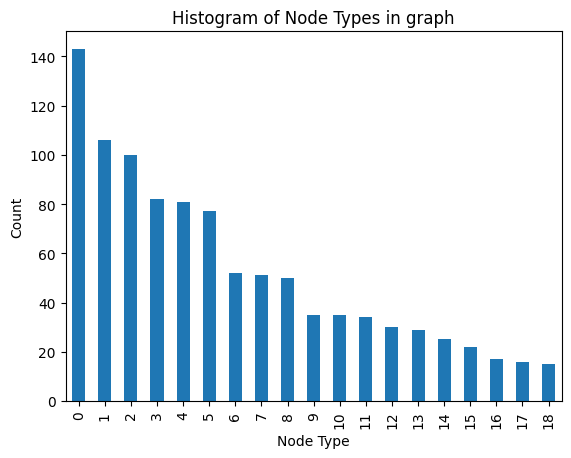

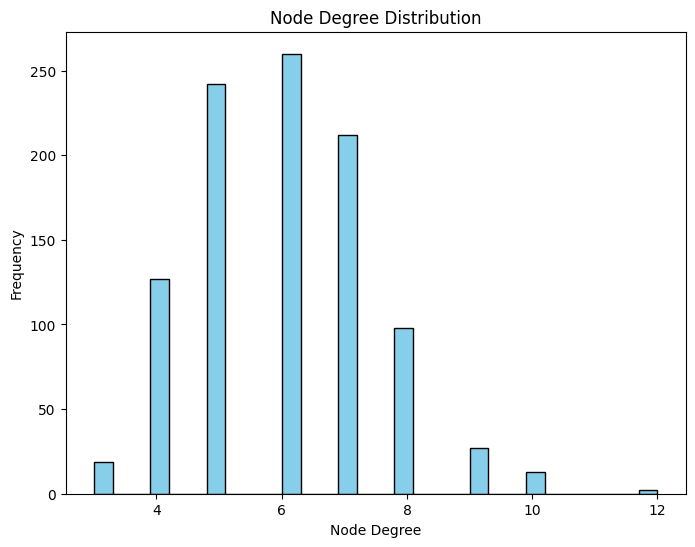

In [35]:
graph_vis.pyg_graph_data_visualizer(data_list[0])

Node labels:  {0: 0, 1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 1, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 3, 19: 1, 20: 1, 21: 2, 22: 2, 23: 3, 24: 3, 25: 2, 26: 3, 27: 3, 28: 2, 29: 2, 30: 3}
y attribute used for node labels


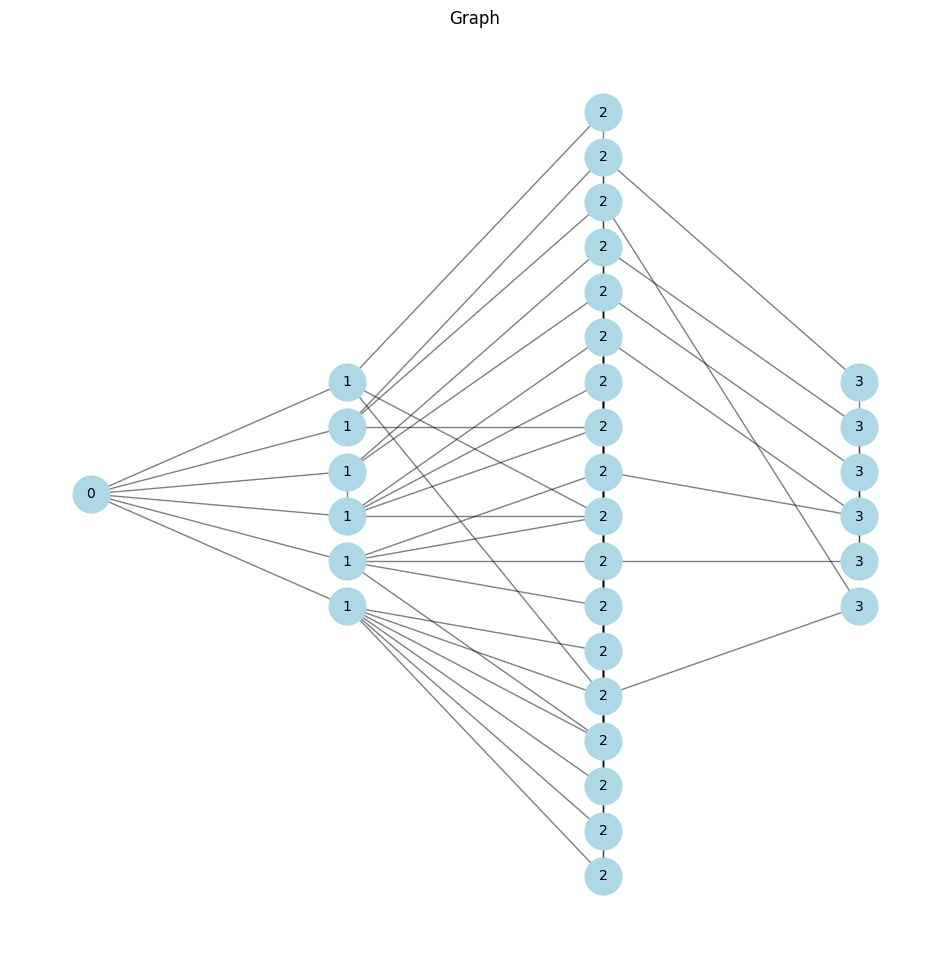


----------Basic graph information-----------
Type:  <class 'networkx.classes.graph.Graph'>
Graph with 31 nodes and 53 edges
Graph creation function:  create_hierarchical_graph_new
Number of nodes:  31
Number of edges:  53
Average node degree:  3.4193548387096775
Has isolated nodes:  0
Has self loops:  0
Is directed:  False
----------Graph extra statistics-----------
Number of connected components: 1
Number of nodes in largest component: 31
Average Clustering Coefficient: 0.14930875576036864
Average Shortest Path (Largest Component): 2.838709677419355
Number of Connected Components: 1



In [16]:
g = graph_creation.create_hierarchical_graph_new(branching_factors=[3,3,1,1], noise_edges=0.05)
graph_vis.graph_visualizer(g, layout = "bfs")
graph_vis.print_graph_info_cluster(g)

In [10]:
# I need to create y as well in both graphs. 
# In community we need the same communities to be in same class
# in hiearchy the same level the same class

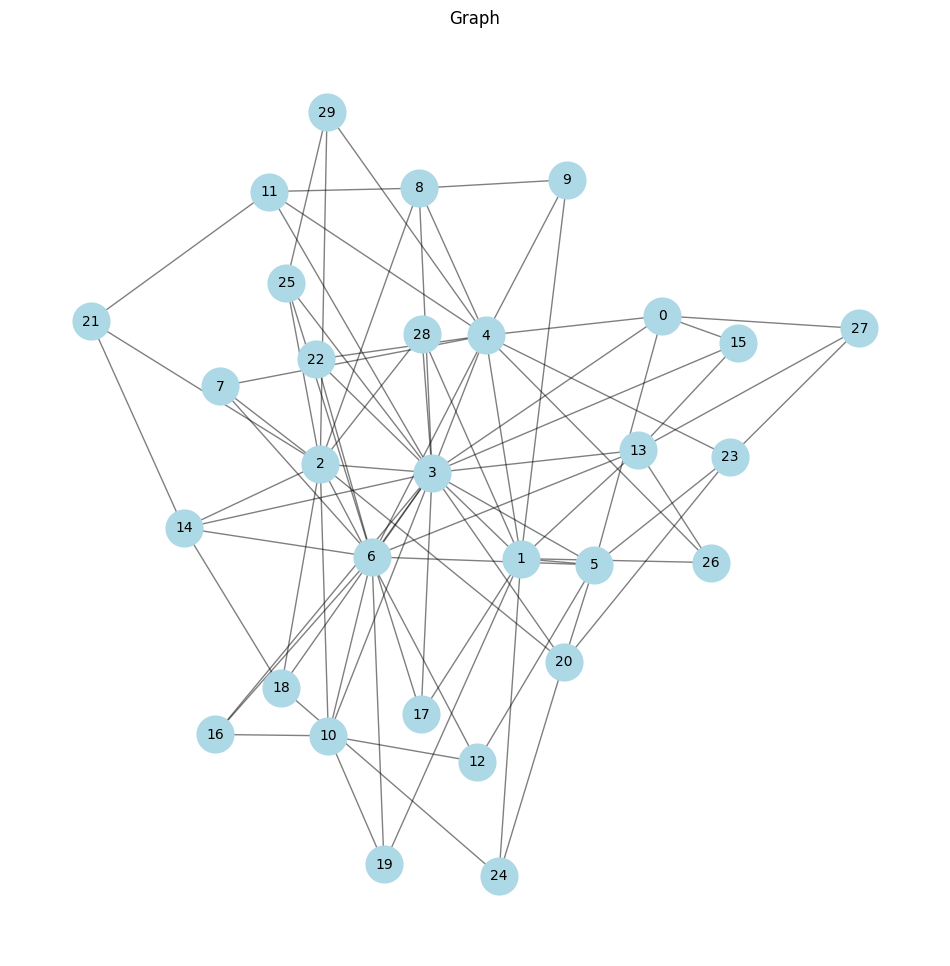

Successfully added 'y' attribute to NetworkX graph with 5 communities found.
Node labels:  {0: 0, 1: 3, 2: 1, 3: 0, 4: 2, 5: 0, 6: 1, 7: 1, 8: 2, 9: 2, 10: 1, 11: 2, 12: 1, 13: 0, 14: 4, 15: 0, 16: 1, 17: 3, 18: 4, 19: 3, 20: 0, 21: 2, 22: 2, 23: 0, 24: 4, 25: 1, 26: 3, 27: 0, 28: 3, 29: 1}
y attribute used for node labels


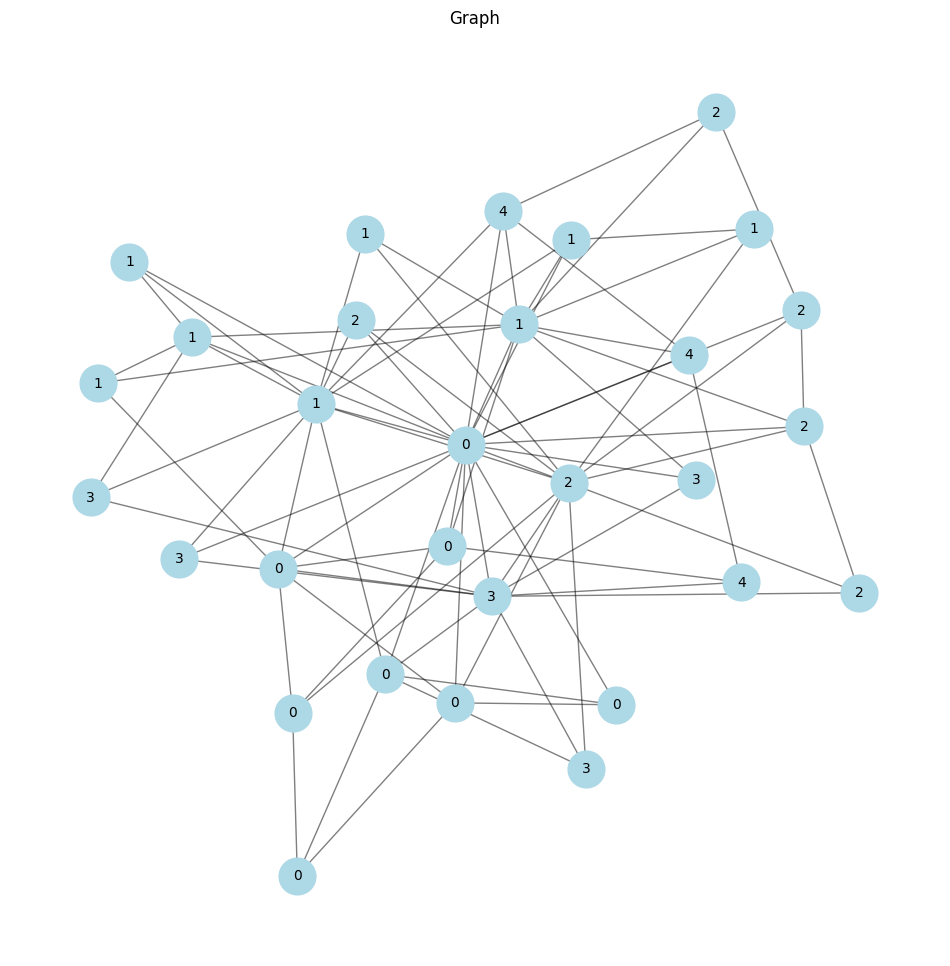

In [49]:
g = nx.powerlaw_cluster_graph(30, 3, 0.1,seed=42)
graph_vis.graph_visualizer(g)
g = utils.add_greedy_modularity_labels_nx(g)
graph_vis.graph_visualizer(g)

0.0


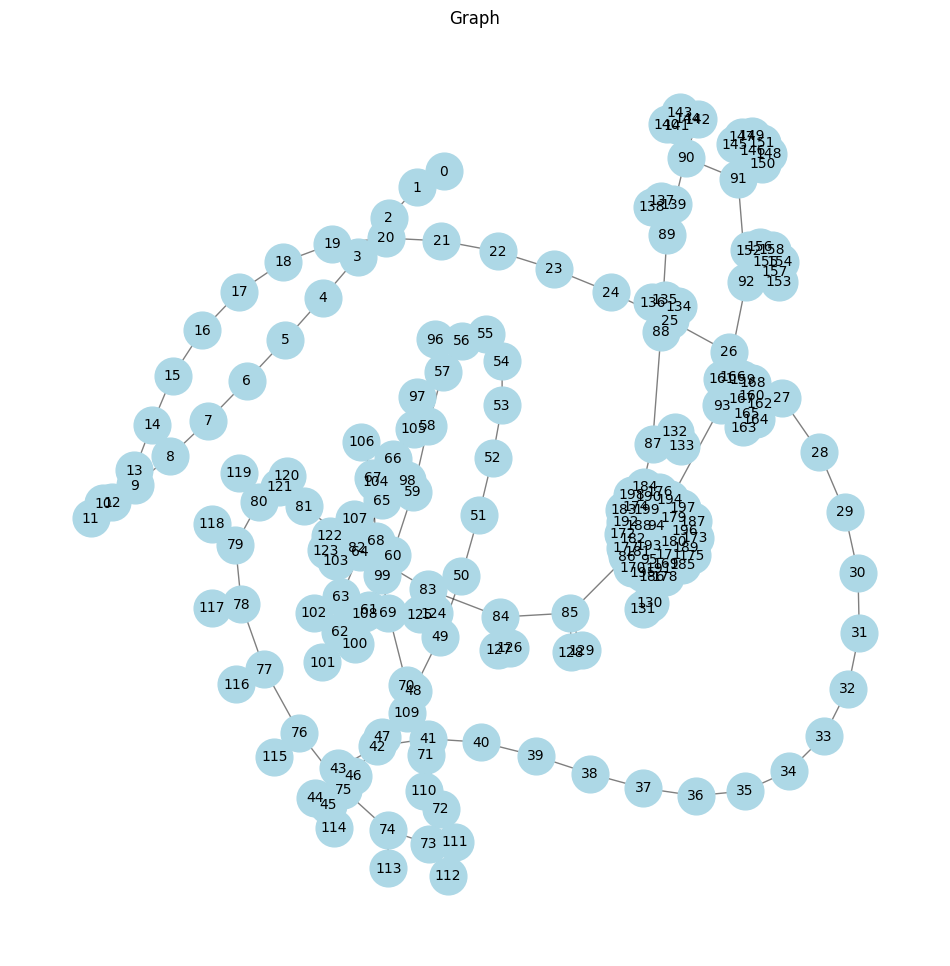

In [13]:
g = nx.random_powerlaw_tree(200, gamma=3, tries=10000)
print(nx.average_clustering(g))
graph_vis.graph_visualizer(g)

In [ ]:
graph_community = graph_creation.graph_with_communities_generator(15,80)# 15,80
print("avg clustering: ",nx.average_clustering(graph_community))
graph_hierarchy = graph_creation.graph_with_hierarchy_generator(2, 10, True) # 2, 10
print("avg clustering: ",nx.average_clustering(graph_hierarchy))


 => Using default probabilities
 => Graph saved to training_data/datasets/graphs/community_graph_15_80.gpickle
avg clustering:  0.3070694197311562
2047
avg clustering:  0.0


TODO:

[ ] try greedy_modularity_communities naming
[ ] try graph genetation based on node degree distribution

In [ ]:
g = nx.karate_club_graph()
g = add_greedy_modularity_labels_nx(g)
data = training.nx_to_pytorch_data_converter(g)
data


Successfully added 'y' attribute to NetworkX graph with 3 communities found.


Data(edge_index=[2, 156], club=[34], weight=[156], name='Zachary's Karate Club', x=[34, 1])

In [ ]:
# nx.random_powerlaw_tree_sequence(10, tries=1000)
graph_community = nx.powerlaw_cluster_graph(n=100,m=1,p=0.8, seed=42)
graph_hierarchy = nx.random_powerlaw_tree(n=100, gamma=3, seed=42, tries=1000000)

training.print_graph_info_cluster(graph_community)
print("############################################")
training.print_graph_info_cluster(graph_hierarchy)


Graph loaded from Graph with 100 nodes and 99 edges
Type:  <class 'networkx.classes.graph.Graph'>
Graph with 100 nodes and 99 edges
Number of nodes:  100
Number of edges:  99
Average node degree:  1.98
Has isolated nodes:  0
Has self loops:  0
Is directed:  False
Graph statistics:
Number of connected components: 1
Number of nodes in largest component: 100
Number of nodes: 100
Number of edges: 99
Average Clustering Coefficient: 0.0
Average Shortest Path (Largest Component): 4.141010101010101
Number of Connected Components: 1
############################################
Graph loaded from Graph with 100 nodes and 99 edges
Type:  <class 'networkx.classes.graph.Graph'>
Graph with 100 nodes and 99 edges
Number of nodes:  100
Number of edges:  99
Average node degree:  1.98
Has isolated nodes:  0
Has self loops:  0
Is directed:  False
Graph statistics:
Number of connected components: 1
Number of nodes in largest component: 100
Number of nodes: 100
Number of edges: 99
Average Clustering Coeffic

In [72]:
graph_community.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99))

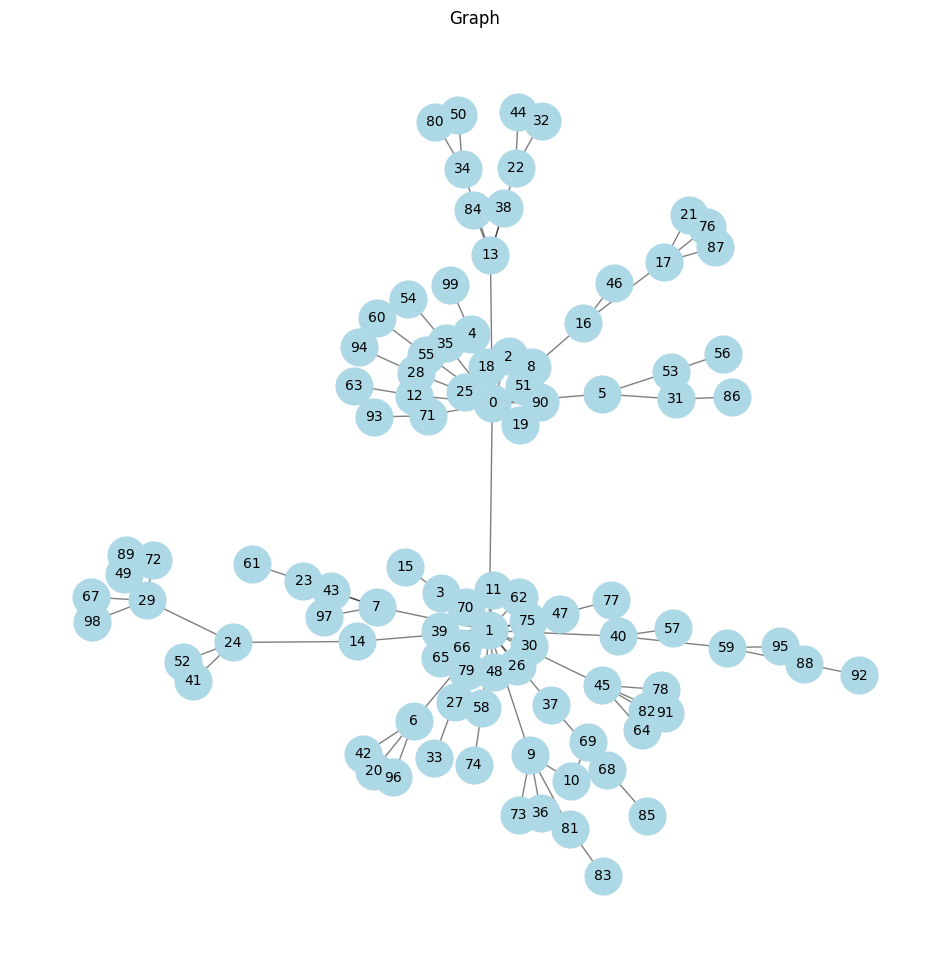

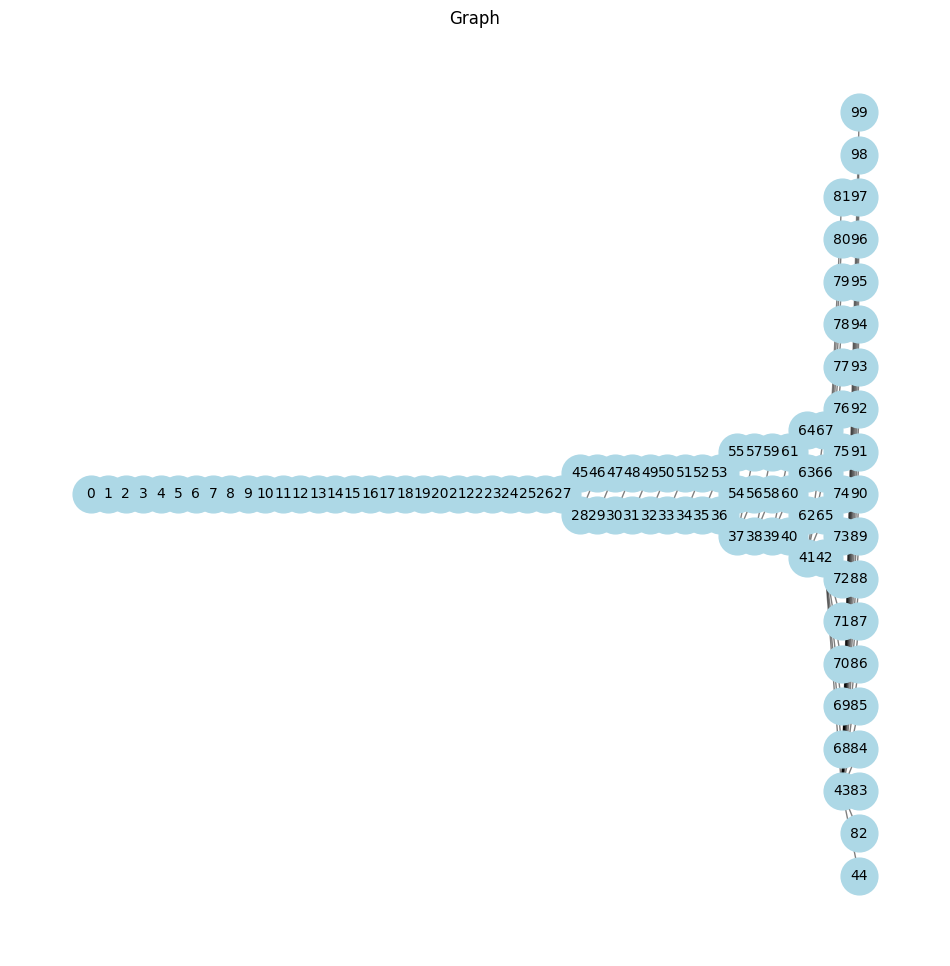

In [ ]:
training.graph_visualizer(graph_community, layout='spring')
training.graph_visualizer(graph_hierarchy, layout='bfs')  

In [ ]:
# y data creation
# these vs the greedy modularity communities

# Compute communities using Louvain algorithm
partition = community_louvain.best_partition(graph_community, random_state=42)
# Assign labels
print("Community labels:")
print(partition)
nx.set_node_attributes(graph_community, partition, 'y')



# Define the root node (usually 0 for these trees)
root_node = 0
# Compute shortest path length from the root node (depth)
depths = nx.single_source_shortest_path_length(graph_hierarchy, root_node)
# Assign depth-based labels
print("Depth labels:")
print(depths)
nx.set_node_attributes(graph_hierarchy, depths, 'y')


# TODO: is the y the same when transforming to torch_geometric data?


Community labels:
{0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 4, 6: 5, 7: 3, 8: 0, 9: 7, 10: 7, 11: 1, 12: 0, 13: 10, 14: 6, 15: 1, 16: 2, 17: 2, 18: 0, 19: 0, 20: 5, 21: 2, 22: 10, 23: 3, 24: 6, 25: 0, 26: 1, 27: 1, 28: 0, 29: 6, 30: 1, 31: 4, 32: 10, 33: 1, 34: 10, 35: 0, 36: 7, 37: 8, 38: 10, 39: 1, 40: 11, 41: 6, 42: 5, 43: 3, 44: 10, 45: 9, 46: 2, 47: 1, 48: 1, 49: 6, 50: 10, 51: 0, 52: 6, 53: 4, 54: 0, 55: 0, 56: 4, 57: 11, 58: 1, 59: 11, 60: 0, 61: 3, 62: 1, 63: 0, 64: 9, 65: 1, 66: 1, 67: 6, 68: 8, 69: 7, 70: 1, 71: 0, 72: 6, 73: 7, 74: 1, 75: 1, 76: 2, 77: 1, 78: 9, 79: 1, 80: 10, 81: 7, 82: 9, 83: 7, 84: 10, 85: 8, 86: 4, 87: 2, 88: 11, 89: 6, 90: 0, 91: 9, 92: 11, 93: 0, 94: 0, 95: 11, 96: 5, 97: 3, 98: 6, 99: 0}
Depth labels:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 45: 28, 29: 29, 46: 29, 30: 30, 47: 30, 31: 31, 4

Node labels:  {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 4, 6: 5, 7: 3, 8: 0, 9: 7, 10: 7, 11: 1, 12: 0, 13: 10, 14: 6, 15: 1, 16: 2, 17: 2, 18: 0, 19: 0, 20: 5, 21: 2, 22: 10, 23: 3, 24: 6, 25: 0, 26: 1, 27: 1, 28: 0, 29: 6, 30: 1, 31: 4, 32: 10, 33: 1, 34: 10, 35: 0, 36: 7, 37: 8, 38: 10, 39: 1, 40: 11, 41: 6, 42: 5, 43: 3, 44: 10, 45: 9, 46: 2, 47: 1, 48: 1, 49: 6, 50: 10, 51: 0, 52: 6, 53: 4, 54: 0, 55: 0, 56: 4, 57: 11, 58: 1, 59: 11, 60: 0, 61: 3, 62: 1, 63: 0, 64: 9, 65: 1, 66: 1, 67: 6, 68: 8, 69: 7, 70: 1, 71: 0, 72: 6, 73: 7, 74: 1, 75: 1, 76: 2, 77: 1, 78: 9, 79: 1, 80: 10, 81: 7, 82: 9, 83: 7, 84: 10, 85: 8, 86: 4, 87: 2, 88: 11, 89: 6, 90: 0, 91: 9, 92: 11, 93: 0, 94: 0, 95: 11, 96: 5, 97: 3, 98: 6, 99: 0}


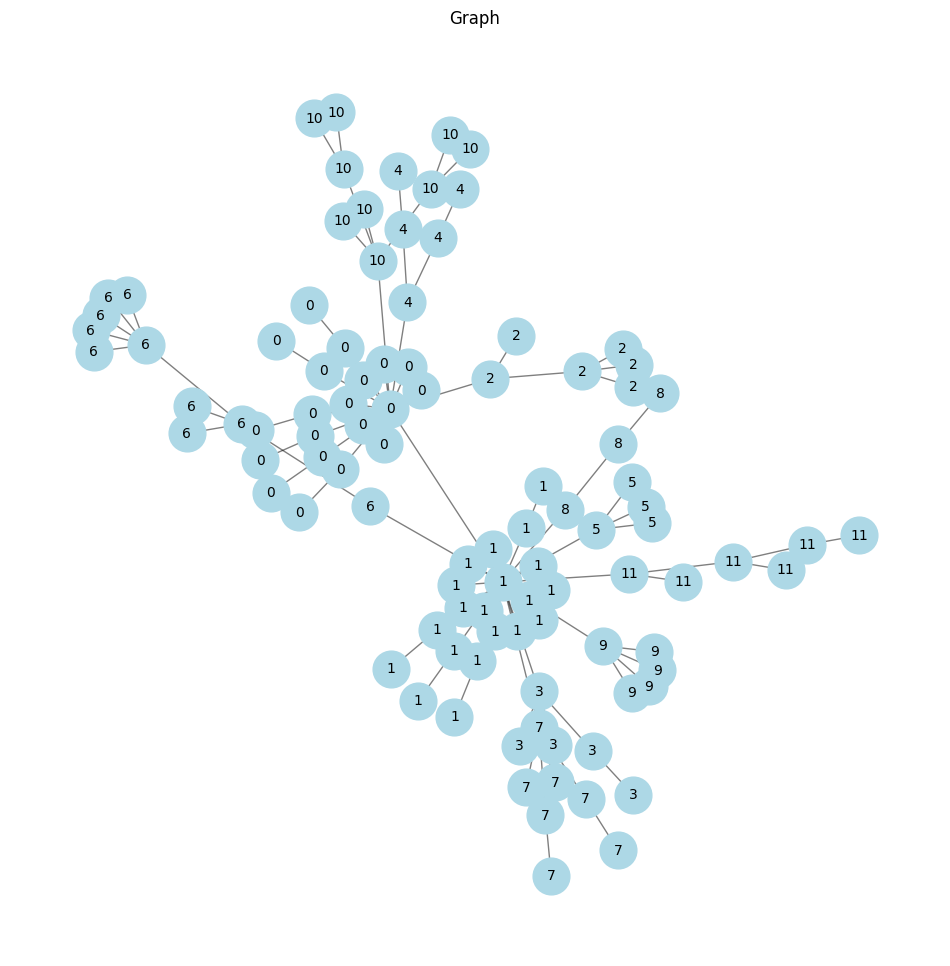

Node labels:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 28, 46: 29, 47: 30, 48: 31, 49: 32, 50: 33, 51: 34, 52: 35, 53: 36, 54: 37, 55: 37, 56: 38, 57: 38, 58: 39, 59: 39, 60: 40, 61: 40, 62: 41, 63: 41, 64: 41, 65: 42, 66: 42, 67: 42, 68: 43, 69: 43, 70: 43, 71: 43, 72: 43, 73: 43, 74: 43, 75: 43, 76: 43, 77: 43, 78: 43, 79: 43, 80: 43, 81: 43, 82: 44, 83: 44, 84: 44, 85: 44, 86: 44, 87: 44, 88: 44, 89: 44, 90: 44, 91: 44, 92: 44, 93: 44, 94: 44, 95: 44, 96: 44, 97: 44, 98: 44, 99: 44}


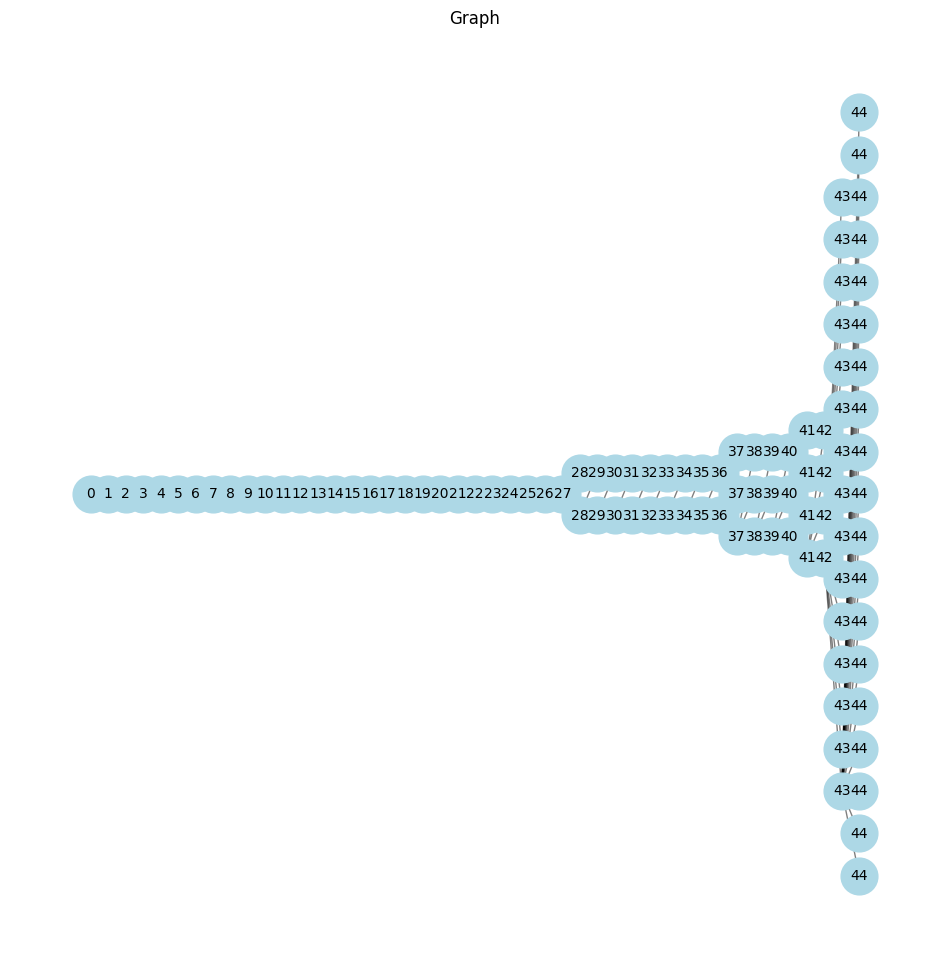

In [ ]:
training.graph_visualizer(graph_community, layout='spring')
training.graph_visualizer(graph_hierarchy, layout='bfs')  

In [ ]:
def nx_to_pytorch_data_converter(G, fill_y = True):
    '''
    This function converts a networkx graph to a pytorch geometric graph.
    TODO: vice versa?
    '''
    assert isinstance(G, nx.Graph), "Graph must be a networkx graph object"
    # y should be the transferred node labels, if they exist

    y = torch.tensor([G.nodes[node]['y'] for node in G.nodes], dtype=torch.long)
    G.graph["num_classes"] = len(set(y.numpy()))

    data = from_networkx(G, group_node_attrs = y)

    if fill_y:
        # Fill in the y attribute for the data object
        data.y = y
    # Add edge index and edge attributes

    return data

data_community = nx_to_pytorch_data_converter(graph_community)
data_community = training.create_masks(data_community)

data_hierarchy = nx_to_pytorch_data_converter(graph_hierarchy)
data_hierarchy = training.create_masks(data_hierarchy)

In [ ]:
training.print_graph_info_basic(data_community)
print("---------")
training.print_graph_info_basic(data_hierarchy)

Type:  <class 'torch_geometric.data.data.Data'>
Data(edge_index=[2, 198], num_classes=12, x=[100, 1], y=[100], train_mask=[100], test_mask=[100])
Keys of the data object: ['edge_index', 'y', 'x', 'train_mask', 'num_classes', 'test_mask']

Has isolated nodes: False
Has self loops: False
Is directed: False

Number of nodes: 100
Number of edges: 198
Average node degree: 1.98
Number of node features: 1
Number of edge features: 0
Number of classes: 12
---------
Type:  <class 'torch_geometric.data.data.Data'>
Data(edge_index=[2, 198], num_classes=45, x=[100, 1], y=[100], train_mask=[100], test_mask=[100])
Keys of the data object: ['edge_index', 'y', 'x', 'train_mask', 'num_classes', 'test_mask']

Has isolated nodes: False
Has self loops: False
Is directed: False

Number of nodes: 100
Number of edges: 198
Average node degree: 1.98
Number of node features: 1
Number of edge features: 0
Number of classes: 45


Node type information available for histogram.
     node_type  count
0           0     20
1           1     20
2           2      6
3           3      5
4           4      5
5           5      4
6           6     10
7           7      7
8           8      3
9           9      5
10         10      9
11         11      6


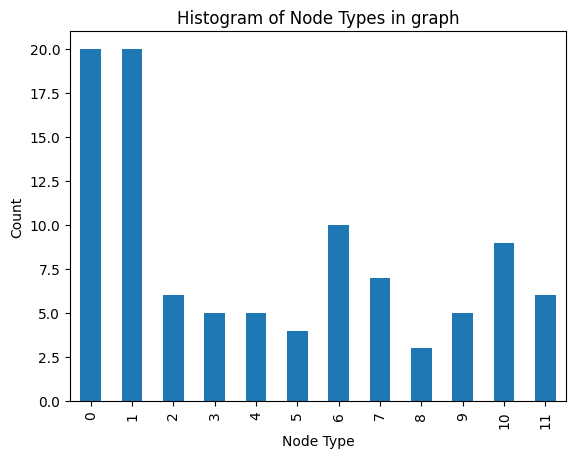

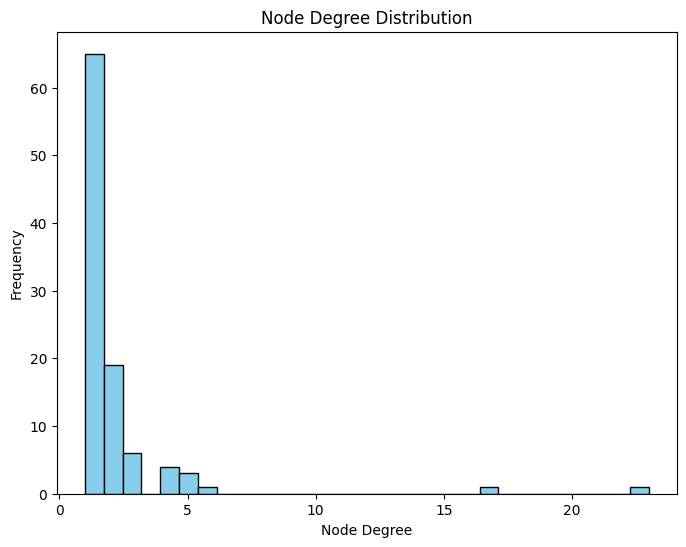

Node type information available for histogram.
     node_type  count
0           0      1
1           1      1
2           2      1
3           3      1
4           4      1
5           5      1
6           6      1
7           7      1
8           8      1
9           9      1
10         10      1
11         11      1
12         12      1
13         13      1
14         14      1
15         15      1
16         16      1
17         17      1
18         18      1
19         19      1
20         20      1
21         21      1
22         22      1
23         23      1
24         24      1
25         25      1
26         26      1
27         27      1
28         28      2
29         29      2
30         30      2
31         31      2
32         32      2
33         33      2
34         34      2
35         35      2
36         36      2
37         37      3
38         38      3
39         39      3
40         40      3
41         41      4
42         42      4
43         43     15
44     

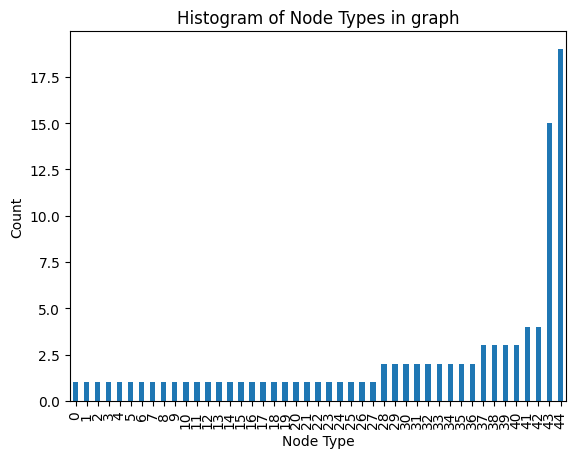

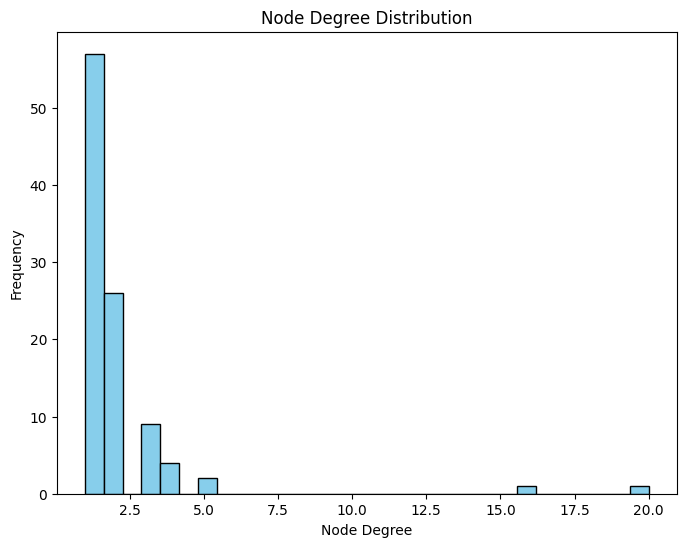

In [ ]:
training.pyg_graph_data_visualizer(data_community)
training.pyg_graph_data_visualizer(data_hierarchy)

In [59]:
# print(len(data_community.train_mask))
# print(len(data_community.test_mask))
# 
# print(len(data_hierarchy.train_mask))
# print(len(data_hierarchy.test_mask))
# 
# print(data_community.y)
# graph_lib.pyg_graph_data_visualizer(data_hierarchy)
# graph_lib.graph_visualizer(graph_community, layout='spring')
# graph_lib.graph_visualizer(graph_hieararchy, layout='bfs')   

In [60]:
model_params_community = {
    "embedding_dim": 128,
    "walk_length": 20,
    "context_size": 10,
    "walks_per_node": 20,
    "num_negative_samples": 5,
    "p": 1,
    "q": 200,
    "sparse": True
    }

model_params_hierarchy = {
    "embedding_dim": 128,
    "walk_length": 20,
    "context_size": 10,
    "walks_per_node": 20,
    "num_negative_samples": 5,
    "p": 200,
    "q": 1,
    "sparse": True
    }

model_community = Node2Vec(data_community.edge_index, **model_params_community)
loader_community = model_community.loader(batch_size=128, shuffle=True, num_workers=0) # num_workers=0 is necessary for Windows
optimizer_community = torch.optim.SparseAdam(list(model_community.parameters()), lr=0.03)

model_hierarchy = Node2Vec(data_hierarchy.edge_index, **model_params_hierarchy)
loader_hierarchy = model_hierarchy.loader(batch_size=128, shuffle=True, num_workers=0) # num_workers=0 is necessary for Windows
optimizer_hierarchy = torch.optim.SparseAdam(list(model_hierarchy.parameters()), lr=0.03)

In [61]:
def train(model, loader, optimizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader): # goes through batches
        optimizer.zero_grad() # Before computing the gradients for the current batch, the gradients from the previous batch are cleared using
        loss = model.loss(pos_rw.to(device), neg_rw.to(device)) # loss / objective function
        loss.backward() # backprop
        optimizer.step() # update parameters
        total_loss += loss.item() # total lossba megy - egy 
    return total_loss / len(loader) # average loss/batch

In [62]:
@torch.no_grad()
def test(model, data):
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

In [63]:
def train_and_test(model, loader, optimizer, data, epochs=10):

    start_time = time.time()
    # for epoch in range(1, 201):
    for epoch in range(epochs):
        epoch_start_time = time.time()
        loss = train(model, loader, optimizer)
        acc = test(model, data)
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')
        epoch_duration = time.time() - epoch_start_time
        print(f'Last epoch duration: {epoch_duration:.2f} seconds')

    elapsed_time = time.time() - start_time
    print(f'Total elapsed time: {elapsed_time:.2f} seconds')
    # torch.save(model.state_dict(), 'node2vec_model.pth')

In [64]:
train_and_test(model_hierarchy, loader_hierarchy, optimizer_hierarchy, data_hierarchy, epochs=10)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 00, Loss: 9.7206, Acc: 0.0667
Last epoch duration: 2.43 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 01, Loss: 8.4291, Acc: 0.1000
Last epoch duration: 2.53 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 02, Loss: 7.3783, Acc: 0.1333
Last epoch duration: 3.45 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 03, Loss: 6.6150, Acc: 0.1333
Last epoch duration: 3.09 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 04, Loss: 6.0338, Acc: 0.1333
Last epoch duration: 2.91 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 05, Loss: 5.5861, Acc: 0.1333
Last epoch duration: 3.18 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 06, Loss: 5.2469, Acc: 0.1667
Last epoch duration: 2.94 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 07, Loss: 4.9664, Acc: 0.1667
Last epoch duration: 2.87 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 08, Loss: 4.6991, Acc: 0.2000
Last epoch duration: 2.63 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 09, Loss: 4.5257, Acc: 0.2000
Last epoch duration: 2.64 seconds
Total elapsed time: 28.67 seconds


In [65]:
train_and_test(model_community, loader_community, optimizer_community, data_community, epochs=10)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 00, Loss: 8.3893, Acc: 0.0667
Last epoch duration: 3.15 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 01, Loss: 7.1129, Acc: 0.1000
Last epoch duration: 2.84 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 02, Loss: 6.0727, Acc: 0.1000
Last epoch duration: 3.13 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 03, Loss: 5.4726, Acc: 0.1333
Last epoch duration: 3.04 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 04, Loss: 5.1190, Acc: 0.1333
Last epoch duration: 3.06 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 05, Loss: 4.8042, Acc: 0.1333
Last epoch duration: 2.91 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 06, Loss: 4.5981, Acc: 0.1333
Last epoch duration: 2.74 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 07, Loss: 4.4344, Acc: 0.1333
Last epoch duration: 3.05 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 08, Loss: 4.2813, Acc: 0.1333
Last epoch duration: 2.70 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 09, Loss: 4.1574, Acc: 0.1667
Last epoch duration: 3.23 seconds
Total elapsed time: 29.85 seconds


In [43]:
# Step 3: Evaluation function (common)
def evaluate_embedding(model, data, mask):
    model.eval()
    embeddings = model().detach().cpu().numpy()
    labels = data.y.cpu().numpy()

    train_embeddings = embeddings[data.train_mask]
    train_labels = labels[data.train_mask]

    test_embeddings = embeddings[data.test_mask]
    test_labels = labels[data.test_mask]

    classifier = LogisticRegression(max_iter=500)
    classifier.fit(train_embeddings, train_labels)

    predictions = classifier.predict(test_embeddings)
    accuracy = accuracy_score(test_labels, predictions)
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

# Evaluation
evaluate_embedding(model_community, data_community, data_community.test_mask)
evaluate_embedding(model_hierarchy, data_hierarchy, data_hierarchy.test_mask)

Test Accuracy: 0.5000
Test Accuracy: 0.1667


0.16666666666666666

In [44]:
@torch.no_grad()
def test(model, data):
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

In [45]:
start_time = time.time()
# for epoch in range(1, 201):
for epoch in range(1, 12):
    epoch_start_time = time.time()
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')
    epoch_duration = time.time() - epoch_start_time
    print(f'Last epoch duration: {epoch_duration:.2f} seconds')

elapsed_time = time.time() - start_time
print(f'Total elapsed time: {elapsed_time:.2f} seconds')
torch.save(model.state_dict(), 'node2vec_model.pth')

TypeError: train() missing 3 required positional arguments: 'model', 'loader', and 'optimizer'

Meg kell határozzuk, hogy milyen graph tulajdonság az ami a dps or bfs irányt preferálja
We can generate graphs like that, only changing that parameter?

utána megnézzük hogy egy-egy bfs vs dfs heavy embedding hogyan megy rajtuk
2x2 mátrix

1) generate graphs
2) create two algorithms
3) score the algos on all cases

közepes gráf 0.5, 0.5 - equally important esetbeb lesz legjobb?
hyperparameter tuning? - just for fun - innen is ki lehetne hozni, hogy melyik irányba húznak 

In [ ]:
# Get model parameters, form saved files if  possible
try:
    with open("node2vec_params.json", "r") as f:
        model_params = json.load(f)

except Exception as e:
    print(f"Error occured: {e.args[1]}")
    print("Loading default model params")

    model_params = {
    "embedding_dim": 128,
    "walk_length": 20,
    "context_size": 10,
    "walks_per_node": 20,
    "num_negative_samples": 1,
    "p": 200,
    "q": 1,
    "sparse": True
    }

In [ ]:
# Recreate the model with loaded parameters
# If not start a quick training? TODO
# We need a folder solution for the saved models and their parameters
# Should We resave after each training?
model = Node2Vec(data.edge_index, **model_params)

try:
    model.load_state_dict(torch.load('node2vec_model.pth'))
except Exception as e:
    print(f"Error occured: {e.args[1]}")
    print("Could not load the model from the file")

# Here the model should be trained TODO

model.eval()

In [ ]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=0) 
# num_workers=0 is necessary for Windows
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [ ]:
assert model.embedding_dim == model_params["embedding_dim"]
# assert model.walk_length == model_params["walk_length"]
assert model.context_size == model_params["context_size"]
assert model.walks_per_node == model_params["walks_per_node"]
assert model.num_negative_samples == model_params["num_negative_samples"]
assert model.p == model_params["p"]
assert model.q == model_params["q"]

print("Model parameters match successfully!")

In [ ]:
model.walk_length

In [ ]:
model_params["walk_length"]

In [ ]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader): 
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [ ]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

In [ ]:
start_time = time.time()
# for epoch in range(1, 201):
for epoch in range(1, 12):
    epoch_start_time = time.time()
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')
    epoch_duration = time.time() - epoch_start_time
    print(f'Last epoch duration: {epoch_duration:.2f} seconds')

elapsed_time = time.time() - start_time
print(f'Total elapsed time: {elapsed_time:.2f} seconds')
torch.save(model.state_dict(), 'node2vec_model.pth')

In [ ]:
@torch.no_grad()
def plot_points(model, colors):
    model.eval() # nograd bc of this? TODO
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(model,colors)

In [ ]:
# Community Graph masks
def create_masks(data, train_ratio=0.7):
    num_nodes = data.num_nodes
    indices = torch.randperm(num_nodes)
    train_size = int(train_ratio * num_nodes)
    
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    
    train_mask[indices[:train_size]] = True
    test_mask[indices[train_size:]] = True
    
    data.train_mask = train_mask
    data.test_mask = test_mask
    return data

data_community = create_masks(data_community)
